## combine cp_df (CellProfiler Output) and soma_df (Barcode Calling Output) to create ann data object - for each sample

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
from imageio import volread as imread
from skimage.filters import threshold_otsu

from skimage import measure
from scipy import stats
import umap
from sklearn.decomposition import PCA
import math

In [2]:
print(os.getcwd())

/Volumes/imagestore/Brian/src


In [3]:
# 101222_D10_Coverslip1_Processed
# 102022_D10_Coverslip2_Reimage_Processed
# 101422_D10_Coverslip3_Processed
# 102222_D10_Coverslip4_Reimage_Processed
# 101922_D10_Coverslip5_Processed
DATA_DIR = '101222_D10_Coverslip1_Processed'
os.chdir(f'../{DATA_DIR}')
print(os.getcwd())

/Volumes/imagestore/Brian/101222_D10_Coverslip1_Processed


In [10]:
CP_DIR = 'cp_output_cellpose'
# Load Feature Data
MP_DIR = 'mp_score_max'
DATA_DIR = 'max'
Compartment = 'Soma_filtered'
DATA_TYPE = 'max_clean'
META_DIR = 'metadata'
SAMPLE = 'Coverslip1'

In [11]:
_allFOVs = sorted(glob.glob(f'./{MP_DIR}/*'))
allFOVs = [x.split('F')[-1][:3] for x in _allFOVs]
len(allFOVs)

225

## Filter only infected cells and synchronize with cp_df, check mask label consistency

In [12]:
# load data
soma_df = pd.read_csv(f'{SAMPLE}_soma_final_CellPose.csv',sep=',',index_col=0) # annotation with MP data
cp_df = pd.read_csv(f'{CP_DIR}/CP_Cellpose_{Compartment}_32.csv', index_col=0)

In [17]:
soma_df[soma_df.InfectedCells==1]

,label,Barcode_Idx,SUM,Barcode,RAW,P,LOGIT,ENTROPY,X_NORM,Gene,...,intensity_mean-2,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta,embedding1,embedding2,True_Label,InfectedCells
3,4,intensity_mean-0,0.270628,A2,0.265434,0.980807,3.933812,0.129745,460.463648,PGGT1B,...,190.354966,109.291052,120.989184,112.373648,108.887906,69.365782,8.742785,-1.311771,0,1
5,6,intensity_mean-4,1.397341,C5,0.504649,0.361149,-0.570379,1.708385,894.584727,MINK1,...,137.174041,123.358407,661.359882,116.157817,120.578171,13.815634,1.632277,-5.368250,0,1
8,9,intensity_mean-0,1.426707,A2,1.181975,0.828463,1.574775,0.857376,1207.776634,PGGT1B,...,482.283567,120.099198,137.836673,219.236473,111.112224,263.047094,0.375498,-0.989223,0,1
10,11,intensity_mean-15,0.306499,E8,0.160011,0.522061,0.088303,1.423271,430.605696,WASL,...,116.375378,123.927346,229.749748,127.127144,114.711403,3.199798,12.841065,-2.251666,0,1
14,15,intensity_mean-4,0.786941,C5,0.398723,0.506675,0.026701,1.439258,712.652966,MINK1,...,134.148526,109.676871,523.463719,112.028345,109.189342,22.120181,4.402254,-6.018330,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111499,205,intensity_mean-9,0.753139,D4,0.343522,0.456121,-0.175968,1.780180,566.101977,FAN1,...,117.451014,182.557432,289.506757,161.400338,216.472973,33.915541,8.669675,-3.060530,0,1
111505,211,intensity_mean-9,1.605957,D4,1.116768,0.695391,0.825444,1.269275,1148.715787,FAN1,...,110.213152,316.247166,445.497732,161.036281,372.136054,55.888889,0.565787,-0.810582,0,1
111507,213,intensity_mean-9,0.679756,D4,0.521984,0.767899,1.196487,0.948957,632.333079,FAN1,...,109.371484,195.319108,227.411251,111.230844,231.091174,32.092144,4.541426,-1.320122,0,1
111511,217,intensity_mean-13,0.287512,E4,0.103453,0.359820,-0.576144,1.718396,496.104350,HRAS,...,142.928129,156.400248,352.372986,131.462206,136.312268,6.615861,11.037404,-4.996367,0,1


In [14]:
cp_df

,ImageNumber,ObjectNumber,FileName_Nuclei,FileName_Soma,FileName_max,PathName_Nuclei,PathName_Soma,PathName_max,AreaShape_Area,AreaShape_BoundingBoxArea,...,Texture_Variance_pRPS6_10_02_256,Texture_Variance_pRPS6_10_03_256,Texture_Variance_pRPS6_3_00_256,Texture_Variance_pRPS6_3_01_256,Texture_Variance_pRPS6_3_02_256,Texture_Variance_pRPS6_3_03_256,Texture_Variance_pRPS6_5_00_256,Texture_Variance_pRPS6_5_01_256,Texture_Variance_pRPS6_5_02_256,Texture_Variance_pRPS6_5_03_256
0,1,1,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1136,1480,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,2,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,856,1147,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,1,3,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,833,1140,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,1,4,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1017,1353,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,1,5,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1243,1628,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111510,225,216,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1046,1365,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
111511,225,217,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,807,1120,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
111512,225,218,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1107,1558,...,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
111513,225,219,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1058,1400,...,0.25831,0.0,0.1156,0.108599,0.105577,0.194502,0.180727,0.101454,0.123175,1.0


In [15]:
infected_inds = soma_df[soma_df.InfectedCells == 1].index
cp_df_filtered = cp_df.loc[infected_inds]
cp_df_filtered

,ImageNumber,ObjectNumber,FileName_Nuclei,FileName_Soma,FileName_max,PathName_Nuclei,PathName_Soma,PathName_max,AreaShape_Area,AreaShape_BoundingBoxArea,...,Texture_Variance_pRPS6_10_02_256,Texture_Variance_pRPS6_10_03_256,Texture_Variance_pRPS6_3_00_256,Texture_Variance_pRPS6_3_01_256,Texture_Variance_pRPS6_3_02_256,Texture_Variance_pRPS6_3_03_256,Texture_Variance_pRPS6_5_00_256,Texture_Variance_pRPS6_5_01_256,Texture_Variance_pRPS6_5_02_256,Texture_Variance_pRPS6_5_03_256
3,1,4,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1017,1353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,6,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,678,832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,9,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,998,1248,...,0.000000,0.000000,0.024984,0.082645,0.024984,0.000000,0.058594,0.000000,0.039931,0.000000
10,1,11,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,991,1221,...,1.946101,1.860034,2.284785,2.068021,2.015825,2.058509,2.200754,1.898398,1.842772,1.909547
14,1,15,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,882,1221,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111499,225,205,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,592,812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111505,225,211,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,882,1188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111507,225,213,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1031,1296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111511,225,217,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,807,1120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
# sanity check to see label agreement
np.array_equal(soma_df.loc[infected_inds].label, cp_df_filtered.ObjectNumber)

True

In [19]:
def get_cell_coords(cell_label, coord_data):
    
    x2 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMaximum_X']
    y2 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMaximum_Y']
    x1 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMinimum_X']
    y1 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMinimum_Y']
    
    return round(x1),round(x2),round(y1),round(y2)

991 1017


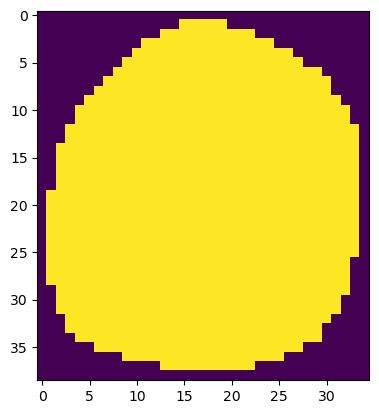

In [23]:
# mask consistency
fov = '000'
label = 11
soma = imread(f'Cellpose_Segmentation_masks/F{fov}_max_Soma.tiff')
df = cp_df_filtered[cp_df_filtered.ImageNumber==1].set_index('ObjectNumber')
print(df.loc[label, 'AreaShape_Area'], np.sum(soma==4))
x1,x2,y1,y2 = get_cell_coords(label, df)
plt.imshow((soma==label)[y1-1:y2+1, x1-1:x2+1])

## Filter NANs, inf, weird features, non-sense features, meta-features

In [30]:
soma_df

,label,Barcode_Idx,SUM,Barcode,RAW,P,LOGIT,ENTROPY,X_NORM,Gene,...,intensity_mean-2,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta,embedding1,embedding2,True_Label,InfectedCells
1,2,intensity_mean-0,0.135188,A2,0.101919,0.753908,1.119566,1.035225,386.916210,PGGT1B,...,149.533879,113.026869,115.473131,152.572430,108.405374,3.038551,12.038923,3.557579,0,0
2,3,intensity_mean-8,0.047468,D3,0.032232,0.679028,0.749309,1.367719,315.950102,PPP2R2B,...,126.888355,121.707083,119.972389,113.175270,121.459784,1.487395,13.519977,8.719123,0,0
3,4,intensity_mean-0,0.270628,A2,0.265434,0.980807,3.933812,0.129745,460.463648,PGGT1B,...,190.354966,109.291052,120.989184,112.373648,108.887906,69.365782,8.742785,-1.311771,0,1
5,6,intensity_mean-4,1.397341,C5,0.504649,0.361149,-0.570379,1.708385,894.584727,MINK1,...,137.174041,123.358407,661.359882,116.157817,120.578171,13.815634,1.632277,-5.368250,0,1
6,7,intensity_mean-1,0.002878,AA5,0.001691,0.587561,0.353892,0.770105,298.880108,MAP4K4,...,111.122999,110.562763,114.749789,120.347094,109.841618,0.560236,14.288588,10.225473,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111509,215,intensity_mean-13,0.036978,E4,0.029647,0.801760,1.397330,0.934359,321.817950,HRAS,...,116.650830,120.838612,148.823529,108.943439,109.590498,1.016591,16.093070,6.735689,0,0
111511,217,intensity_mean-13,0.287512,E4,0.103453,0.359820,-0.576144,1.718396,496.104350,HRAS,...,142.928129,156.400248,352.372986,131.462206,136.312268,6.615861,11.037404,-4.996367,0,1
111512,218,intensity_mean-9,0.189790,D4,0.162014,0.853646,1.763489,0.617955,371.703301,FAN1,...,108.930443,142.222222,114.551039,125.058717,150.981030,17.163505,10.861491,4.165268,0,0
111513,219,intensity_mean-15,1.310673,E8,0.868986,0.663007,0.676725,1.312479,1578.212837,WASL,...,122.333648,356.823251,1333.576560,152.389414,113.064272,204.433837,-2.793087,-3.476730,0,1


In [24]:
for col in cp_df_filtered.columns:
    print(col)

ImageNumber
ObjectNumber
FileName_Nuclei
FileName_Soma
FileName_max
PathName_Nuclei
PathName_Soma
PathName_max
AreaShape_Area
AreaShape_BoundingBoxArea
AreaShape_BoundingBoxMaximum_X
AreaShape_BoundingBoxMaximum_Y
AreaShape_BoundingBoxMinimum_X
AreaShape_BoundingBoxMinimum_Y
AreaShape_Center_X
AreaShape_Center_Y
AreaShape_CentralMoment_0_0
AreaShape_CentralMoment_0_1
AreaShape_CentralMoment_0_2
AreaShape_CentralMoment_0_3
AreaShape_CentralMoment_1_0
AreaShape_CentralMoment_1_1
AreaShape_CentralMoment_1_2
AreaShape_CentralMoment_1_3
AreaShape_CentralMoment_2_0
AreaShape_CentralMoment_2_1
AreaShape_CentralMoment_2_2
AreaShape_CentralMoment_2_3
AreaShape_Compactness
AreaShape_ConvexArea
AreaShape_Eccentricity
AreaShape_EquivalentDiameter
AreaShape_EulerNumber
AreaShape_Extent
AreaShape_FormFactor
AreaShape_HuMoment_0
AreaShape_HuMoment_1
AreaShape_HuMoment_2
AreaShape_HuMoment_3
AreaShape_HuMoment_4
AreaShape_HuMoment_5
AreaShape_HuMoment_6
AreaShape_InertiaTensorEigenvalues_0
AreaShape_I

In [31]:
# divide columns into obsm vs data
veto = ['ImageNumber', 'FileName','PathName','Children','Location', 'Parent',"Number"]
L = cp_df_filtered.columns.tolist()
removeL = []
meta_cols = []
for v in veto:
    for l in L:
        if l.startswith(v): 
            removeL.append(l)

for l in L:
    if 'BoundingBoxMaximum' in l.split('_'):
        removeL.append(l)       
    if 'BoundingBoxMinimum' in l.split('_'):
        removeL.append(l)      
    if "ObjectNumber" in l:
        removeL.append(l)
        
removeL.append('AreaShape_Center_X')
removeL.append('AreaShape_Center_Y')
removeL.append('AreaShape_Area')
removeL.append('AreaShape_BoundingBoxArea')
removeL.append('AreaShape_CentralMoment_0_0')

# remove meta columns to create data dataframe
N = len(L)
for x in removeL: 
    L.remove(x)

# Subset only infected cells !!
infected_cells = soma_df[soma_df.InfectedCells==1].index
data_df = cp_df_filtered[L]
print(N-len(data_df.columns.tolist()), data_df.shape)

# create meta_df
meta_df = cp_df_filtered[removeL]
print(len(meta_df.columns.tolist()), meta_df.shape)

123 (31184, 4125)
123 (31184, 123)


In [38]:
# sanity check: object numbers
print(np.array_equal(cp_df_filtered.loc[infected_cells,'ObjectNumber'], meta_df['ObjectNumber']))
print(np.array_equal(cp_df_filtered.loc[infected_cells, 'AreaShape_CentralMoment_0_1'],
                     data_df['AreaShape_CentralMoment_0_1']))

True
True


## Calculate NAN statistics, filter dataframe

In [39]:
# filter columns
cols = []
for col in data_df.columns:
    if data_df[col].isna().sum() < 1000: # only include features that have less than 1000 NAN cells. 
        cols.append(col)
N = data_df.shape[1]
data_df = data_df[cols]
print("removing features with >1000 NaN values, ", N-data_df.shape[1])

nan_rows = data_df[~data_df.isna().any(axis=1)].index
Ncells = data_df.shape[0]
data_df=data_df.loc[nan_rows,:]
print("removing cells with any NAN column, ", Ncells - data_df.shape[0])

# filter metadata as well
meta_df = meta_df.loc[data_df.index,:]
print('final size, ', data_df.shape, meta_df.shape)

removing features with >1000 NaN values,  8
removing cells with any NAN column,  3789
final size,  (27395, 4117) (27395, 123)


In [40]:
# check NAN
print(sum(data_df.isna().any(axis=0)))
print(sum(data_df.isna().any(axis=1)))

0
0


In [41]:
# combine soma_df and meta_df
dup_cols = []
for col in meta_df.columns:
    if col in soma_df.columns:
        dup_cols.append(col)
col = 'ObjectNumber'
print(np.array_equal(soma_df.loc[meta_df.index,'label'], meta_df[col]))

# concatenate dataframes
include_cols = [x for x in meta_df.columns if x not in dup_cols]
meta_df_final = pd.concat([meta_df[include_cols], soma_df.loc[meta_df.index,:]], axis=1, join='inner')
meta_df_final

True


,FileName_Nuclei,FileName_Soma,FileName_max,PathName_Nuclei,PathName_Soma,PathName_max,Children_Cytoplasm_Count,Location_CenterMassIntensity_X_AGP,Location_CenterMassIntensity_X_DNA,Location_CenterMassIntensity_X_ER,...,intensity_mean-2,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta,embedding1,embedding2,True_Label,InfectedCells
3,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1542.80190,1542.61950,1542.81370,...,190.354966,109.291052,120.989184,112.373648,108.887906,69.365782,8.742785,-1.311771,0,1
5,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1260.57240,1260.28560,1260.40820,...,137.174041,123.358407,661.359882,116.157817,120.578171,13.815634,1.632277,-5.368250,0,1
8,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,130.71431,128.10980,130.95891,...,482.283567,120.099198,137.836673,219.236473,111.112224,263.047094,0.375498,-0.989223,0,1
10,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1352.54220,1352.97360,1352.40440,...,116.375378,123.927346,229.749748,127.127144,114.711403,3.199798,12.841065,-2.251666,0,1
14,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1659.90720,1659.67900,1660.07150,...,134.148526,109.676871,523.463719,112.028345,109.189342,22.120181,4.402254,-6.018330,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111498,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1159.09470,1164.46500,1159.00550,...,110.996599,174.685374,508.533163,565.109694,111.337585,37.076531,3.199667,0.374924,0,1
111499,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1397.28450,1396.74650,1397.25890,...,117.451014,182.557432,289.506757,161.400338,216.472973,33.915541,8.669675,-3.060530,0,1
111507,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,732.26620,734.62714,732.51620,...,109.371484,195.319108,227.411251,111.230844,231.091174,32.092144,4.541426,-1.320122,0,1
111511,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1598.57260,1595.62980,1599.15750,...,142.928129,156.400248,352.372986,131.462206,136.312268,6.615861,11.037404,-4.996367,0,1


In [42]:
# check na
print(sum(meta_df_final.isna().any(axis=1)))
print(sum(meta_df_final.isna().any(axis=0)))

0
0


In [43]:
# final sanity check
np.array_equal(data_df.index, meta_df_final.index)

True

In [44]:
# include 'index' as UMI for later sanity check
meta_df_final['UMI'] = meta_df_final.index
meta_df_final

,FileName_Nuclei,FileName_Soma,FileName_max,PathName_Nuclei,PathName_Soma,PathName_max,Children_Cytoplasm_Count,Location_CenterMassIntensity_X_AGP,Location_CenterMassIntensity_X_DNA,Location_CenterMassIntensity_X_ER,...,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta,embedding1,embedding2,True_Label,InfectedCells,UMI
3,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1542.80190,1542.61950,1542.81370,...,109.291052,120.989184,112.373648,108.887906,69.365782,8.742785,-1.311771,0,1,3
5,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1260.57240,1260.28560,1260.40820,...,123.358407,661.359882,116.157817,120.578171,13.815634,1.632277,-5.368250,0,1,5
8,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,130.71431,128.10980,130.95891,...,120.099198,137.836673,219.236473,111.112224,263.047094,0.375498,-0.989223,0,1,8
10,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1352.54220,1352.97360,1352.40440,...,123.927346,229.749748,127.127144,114.711403,3.199798,12.841065,-2.251666,0,1,10
14,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1659.90720,1659.67900,1660.07150,...,109.676871,523.463719,112.028345,109.189342,22.120181,4.402254,-6.018330,0,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111498,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1159.09470,1164.46500,1159.00550,...,174.685374,508.533163,565.109694,111.337585,37.076531,3.199667,0.374924,0,1,111498
111499,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1397.28450,1396.74650,1397.25890,...,182.557432,289.506757,161.400338,216.472973,33.915541,8.669675,-3.060530,0,1,111499
111507,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,732.26620,734.62714,732.51620,...,195.319108,227.411251,111.230844,231.091174,32.092144,4.541426,-1.320122,0,1,111507
111511,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1598.57260,1595.62980,1599.15750,...,156.400248,352.372986,131.462206,136.312268,6.615861,11.037404,-4.996367,0,1,111511


## Mask out label - for soma version initially. then take processed soma data and make intersections of cell id

In [47]:
meta_df_final['mask_bbox'] = 0
for fov in allFOVs:
    df = meta_df_final[meta_df_final.FileName_max == f'F{fov}_max.tif']
    if os.path.exists(f'./mask/F{fov}_mask.tif'):
        mask = imread(f'./mask/F{fov}_mask.tif').astype('bool') # load mask
        soma = imread(f'./Cellpose_Segmentation_masks/F{fov}_max_Soma.tiff')
        labels = list(set((soma*mask).flatten())) # get cell label number 
        # check if cell label is in df
        for cell in labels:
            if cell in df.label.values:
                # get index
                ind = df[df.label==cell].index
                meta_df_final.loc[ind, 'mask_bbox'] = 1
print("total masked out cells ", (meta_df_final.mask_bbox==1).sum())                

total masked out cells  1


In [49]:
## remove masked out cells
final_inds = meta_df_final[meta_df_final.mask_bbox == 0].index
meta_df_final = meta_df_final.loc[final_inds]
data_df = data_df.loc[final_inds]
print(meta_df_final.shape, data_df.shape)

(27394, 155) (27394, 4117)


In [50]:
print(os.getcwd())

/Volumes/imagestore/Brian/101222_D10_Coverslip1_Processed


In [51]:
if not os.path.exists('adata_Cellpose'):
    os.mkdir('adata_Cellpose')

## Make AnnData

In [53]:
# Make Ann Data Object
adata = sc.AnnData(X=data_df)
adata.obs =  meta_df_final
adata.write(f'adata_Cellpose/{SAMPLE}_adata_Cellpose.h5ad')

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_2969/4284852783.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=data_df)
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [3, 5, 8, 10, 14

## Test

In [54]:
# load adata
adata_loaded = sc.read(f'./adata_Cellpose/{SAMPLE}_adata_Cellpose.h5ad') # 
adata_loaded

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 27394 × 4117
    obs: 'FileName_Nuclei', 'FileName_Soma', 'FileName_max', 'PathName_Nuclei', 'PathName_Soma', 'PathName_max', 'Children_Cytoplasm_Count', 'Location_CenterMassIntensity_X_AGP', 'Location_CenterMassIntensity_X_DNA', 'Location_CenterMassIntensity_X_ER', 'Location_CenterMassIntensity_X_G3BP1', 'Location_CenterMassIntensity_X_GFAP', 'Location_CenterMassIntensity_X_GM130', 'Location_CenterMassIntensity_X_Golgin97', 'Location_CenterMassIntensity_X_LAMP1', 'Location_CenterMassIntensity_X_NFKB', 'Location_CenterMassIntensity_X_NeuN', 'Location_CenterMassIntensity_X_RANGAP1', 'Location_CenterMassIntensity_X_SYTO', 'Location_CenterMassIntensity_X_TDP43', 'Location_CenterMassIntensity_X_TOM20', 'Location_CenterMassIntensity_X_fourHNE', 'Location_CenterMassIntensity_X_pRPS6', 'Location_CenterMassIntensity_Y_AGP', 'Location_CenterMassIntensity_Y_DNA', 'Location_CenterMassIntensity_Y_ER', 'Location_CenterMassIntensity_Y_G3BP1', 'Location_CenterMass

In [55]:
adata_loaded.obs

,FileName_Nuclei,FileName_Soma,FileName_max,PathName_Nuclei,PathName_Soma,PathName_max,Children_Cytoplasm_Count,Location_CenterMassIntensity_X_AGP,Location_CenterMassIntensity_X_DNA,Location_CenterMassIntensity_X_ER,...,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta,embedding1,embedding2,True_Label,InfectedCells,UMI,mask_bbox
3,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1542.80190,1542.61950,1542.81370,...,120.989184,112.373648,108.887906,69.365782,8.742785,-1.311771,0,1,3,0
5,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1260.57240,1260.28560,1260.40820,...,661.359882,116.157817,120.578171,13.815634,1.632277,-5.368250,0,1,5,0
8,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,130.71431,128.10980,130.95891,...,137.836673,219.236473,111.112224,263.047094,0.375498,-0.989223,0,1,8,0
10,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1352.54220,1352.97360,1352.40440,...,229.749748,127.127144,114.711403,3.199798,12.841065,-2.251666,0,1,10,0
14,F000_Nuclei_max_cp_masks.tif,F000_Soma_max_cp_masks.tif,F000_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1659.90720,1659.67900,1660.07150,...,523.463719,112.028345,109.189342,22.120181,4.402254,-6.018330,0,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111498,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1159.09470,1164.46500,1159.00550,...,508.533163,565.109694,111.337585,37.076531,3.199667,0.374924,0,1,111498,0
111499,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1397.28450,1396.74650,1397.25890,...,289.506757,161.400338,216.472973,33.915541,8.669675,-3.060530,0,1,111499,0
111507,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,732.26620,734.62714,732.51620,...,227.411251,111.230844,231.091174,32.092144,4.541426,-1.320122,0,1,111507,0
111511,F224_Nuclei_max_cp_masks.tif,F224_Soma_max_cp_masks.tif,F224_max.tif,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,/media/imaging/Expansion/101222_D10_Coverslip1...,1,1598.57260,1595.62980,1599.15750,...,352.372986,131.462206,136.312268,6.615861,11.037404,-4.996367,0,1,111511,0


In [56]:
adata_loaded.var

""
AreaShape_CentralMoment_0_1
AreaShape_CentralMoment_0_2
AreaShape_CentralMoment_0_3
AreaShape_CentralMoment_1_0
AreaShape_CentralMoment_1_1
...
Texture_Variance_pRPS6_3_03_256
Texture_Variance_pRPS6_5_00_256
Texture_Variance_pRPS6_5_01_256
Texture_Variance_pRPS6_5_02_256
